## Extracting Rayleigh wave from seismometers
We use seimic catalogs and seismometer data downloaded using ObsPy to extract Rayleigh wave waveforms. These waveforms can be scaled and added to balloon pressure waveforms to build realistic synthetic data to train an anomaly detector.

In [2]:
%matplotlib notebook
import pandas as pd
import numpy as np
from obspy.core.utcdatetime import UTCDateTime
import importlib
import matplotlib.pyplot as plt
import os
import seaborn as sns
import obspy
from obspy.clients.fdsn import Client

## USGS data + Alaskan quakes

In [3]:
from obspy.clients.fdsn import Client
client = Client("IRIS")
t1 = UTCDateTime("2018-01-01T00:00:00")
t2 = UTCDateTime("2023-01-01T00:00:00")
cat = client.get_events(starttime=t1, endtime=t2, 
                        minmagnitude=6.3, 
                        maxdepth=40.,
                        minlatitude=52, minlongitude=-175,
                        maxlatitude=70, maxlongitude=-130)
print(cat)

9 Event(s) in Catalog:
2022-01-11T12:39:31.515000Z | +52.605, -168.155 | 6.6  Mww
2022-01-11T11:35:46.156000Z | +52.656, -167.917 | 6.8  mww
2021-08-14T11:57:43.430000Z | +55.173, -157.653 | 6.9  Mww
2021-07-29T06:15:49.188000Z | +55.364, -157.888 | 8.2  Mww
2020-12-01T16:22:39.908000Z | +52.752, -168.231 | 6.4  mww
2020-10-19T20:54:39.436000Z | +54.609, -159.652 | 7.6  Mww
2020-07-22T06:12:44.593000Z | +55.030, -158.522 | 7.8  Mww
2018-08-12T14:58:54.286000Z | +69.562, -145.300 | 6.3  ml
2018-01-23T09:31:42.940000Z | +56.046, -149.073 | 7.9  Mww


In [4]:
from obspy.geodetics import gps2dist_azimuth
from tqdm import tqdm

vel_RW = 3.5
for ev in cat[8:]:
    origin = ev.origins[0]
    origin_time = origin.time
    lat_ev = origin.latitude
    lon_ev = origin.longitude
    inventory = client.get_stations(network="*", station="*", channel='BHZ',
                                    latitude=lat_ev, longitude=lon_ev, 
                                    maxradius=10)
    
    if True:
        st = obspy.Stream()
        for net in inventory:
            for stat in tqdm(net):
                lat, lon = stat.latitude, stat.longitude
                dist, _, _ = gps2dist_azimuth(lat_ev, lon_ev, lat, lon)
                t1 = origin_time + dist*1e-3/vel_RW - 360.
                t2 = t1 + 3600.
                #print(net.code, stat.code, t1, t2)
                try:
                    st_loc = client.get_waveforms(net.code, stat.code, "*", "BHZ", t1, t2, attach_response=True)
                    for tr in st_loc:
                        tr.stats.dist = dist
                        tr.stats.dist = dist
                    st += st_loc
                except:
                    continue
                    
        metadata = np.array([[tr.stats.network,tr.stats.station,tr.stats.dist] for tr in st])
        metadata = pd.DataFrame(metadata, columns=['network', 'station', 'distance'])
        metadata['ev_time'] = origin_time
        metadata['lat_ev'] = lat_ev
        metadata['lon_ev'] = lon_ev
        metadata['mag'] = ev.magnitudes[0].mag
        metadata['mag_type'] = ev.magnitudes[0].magnitude_type
    break

100%|██████████| 7/7 [00:04<00:00,  1.73it/s]


In [29]:
from obspy.geodetics import gps2dist_azimuth
from tqdm import tqdm

vel_RW = 3.5
for ev in cat[8:]:
    origin = ev.origins[0]
    origin_time = origin.time
    lat_ev = origin.latitude
    lon_ev = origin.longitude
    inventory = client.get_stations(network="*", station="*", channel='BHZ',
                                    latitude=lat_ev, longitude=lon_ev, 
                                    maxradius=10)
    
    if True:
        st_IS = obspy.Stream()
        for net in inventory:
            for stat in tqdm(net):
                lat, lon = stat.latitude, stat.longitude
                dist, _, _ = gps2dist_azimuth(lat_ev, lon_ev, lat, lon)
                t1 = origin_time + dist*1e-3/vel_RW - 360.
                t2 = t1 + 800.
                #print(net.code, stat.code, t1, t2)
                try:
                    st_loc = client.get_waveforms(net.code, stat.code, "*", "BDF", t1, t2, attach_response=True)
                    for tr in st_loc:
                        tr.stats.dist = dist
                        tr.stats.dist = dist
                    st_IS += st_loc
                except:
                    continue
                    
        metadata = np.array([[tr.stats.network,tr.stats.station,tr.stats.dist] for tr in st_IS])
        metadata = pd.DataFrame(metadata, columns=['network', 'station', 'distance'])
        metadata['ev_time'] = origin_time
        metadata['lat_ev'] = lat_ev
        metadata['lon_ev'] = lon_ev
        metadata['mag'] = ev.magnitudes[0].mag
        metadata['mag_type'] = ev.magnitudes[0].magnitude_type
    break

100%|██████████| 7/7 [00:03<00:00,  1.80it/s]


<IPython.core.display.Javascript object>


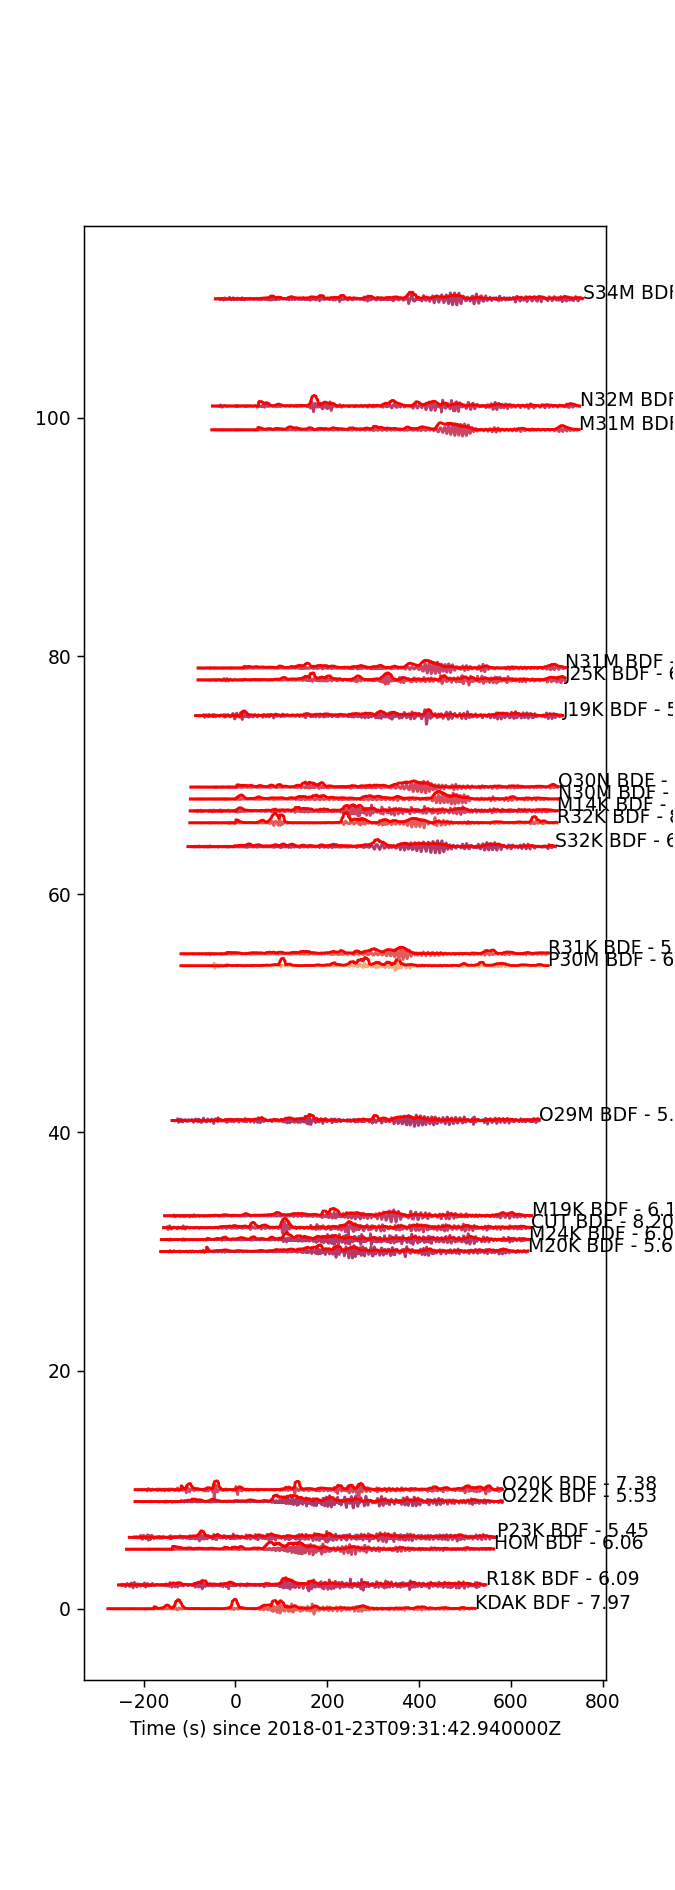

113 113


Text(0.5, 0, 'Time (s) since 2018-01-23T09:31:42.940000Z')

In [49]:
from obspy.signal.trigger import classic_sta_lta

def get_color_from_palette(value, palette_name='flare_r', vmin=0, vmax=1):
    """
    Maps a numerical value to a color from a Seaborn color palette.

    :param value: The numerical value to map.
    :param palette_name: The name of the Seaborn color palette to use.
    :param vmin: Minimum value for normalization.
    :param vmax: Maximum value for normalization.
    :return: The color corresponding to the given value.
    """
    # Create a color palette
    palette = sns.color_palette(palette_name, as_cmap=True)
    
    # Normalize the value
    normalized_value = (value - vmin) / (vmax - vmin)
    
    # Map the normalized value to a color
    color = palette(normalized_value)
    
    return color

#file = './validation_data/ev_2021-07-29T06_Mw8.2'
#st = obspy.read(file)

plt.figure(figsize=(5,14))

st_c = st_IS.copy()
st_c.remove_response()
for tr in st_c:
    #tr.remove_response()
    tr.detrend()
    #tr.filter('highpass', freq=0.05)
    tr.filter('bandpass', freqmin=0.1, freqmax=0.5)
    t1 = origin_time + tr.stats.dist*1e-3/vel_RW - 120.
    t2 = t1 + 6.*60.
    #tr.trim(starttime=t1, endtime=t2)
    
sta, lta = 10., 100.
stations_to_remove = []
#stations_to_remove = ['KOWE', 'RDT', 'O20K', 'O14K', 'I20K', 'M20K'] # Mw 7.6
#stations_to_remove = ['I17K', 'H17K', 'SPU', 'S19K', 'KNK', 'KONW', 'O19K'] # Mw 7.8
stations_to_remove = ['P33M', 'T33K', 'PV6A', 'M17K', 'M23K', 'S31K', 'O19K', 'L26K'] # Mw 
stations_to_use = np.unique([tr.stats.station for tr in st_c])
#stations_to_use = stations

stds = np.array([st_c.select(station=station)[0].data.max()/np.std(st_c.select(station=station)[0].data) for station in stations_to_use])

times = [st_c.select(station=station)[0].stats.starttime - origin_time for station in stations_to_use]
idx = np.argsort(times)
print(len(times), len(idx))
stations = []
for itr, station in enumerate(stations_to_use[:]): 
    
    tr = st_c.select(station=station)[0]
    
    df = 1./tr.stats.delta
    if tr.data.size <= int(lta * df):
        continue
    sta_lta_signal = classic_sta_lta(tr.data, int(sta * df), int(lta * df))
    diff_size = tr.data.size-sta_lta_signal.size
    sta_lta_time = tr.times()[diff_size:]
    area = np.trapz(sta_lta_signal, x=sta_lta_time)
    
    if sta_lta_signal.max() < 5  or area < 705: # Mw 8.2
    #if sta_lta_signal.max() < 5.35  or area < 705: # Mw 7.6
        continue
        
    if tr.stats.station in stations or tr.stats.station in stations_to_remove:
        continue
        
    stations.append(tr.stats.station)
    
    color = get_color_from_palette(stds[itr], vmin=stds.min(), vmax=stds.max())
    offset = tr.stats.starttime - origin_time
    plt.plot(tr.times()+offset, tr.data/(2.*tr.data.max())+np.where(idx==itr)[0][0], color=color)
    plt.plot(sta_lta_time+offset, sta_lta_signal/10.+np.where(idx==itr)[0][0], color='red')
    #plt.text(tr.times()[-1]+offset, np.where(idx==itr)[0][0], f'{tr.stats.station} - {itr}')
    plt.text(tr.times()[-1]+offset, np.where(idx==itr)[0][0], f'{tr.stats.station} {tr.stats.channel} - {sta_lta_signal.max():.2f}')
plt.xlabel(f'Time (s) since {origin_time}')

In [35]:
st_filtered = obspy.Stream()
for stat in stations:
    st_filtered += st.select(station=stat)[0]

file = f'./validation_data/ev_{origin.time.strftime("%Y-%m-%dT%H")}_Mw{ev.magnitudes[0].mag}.mseed'
#st_filtered.write(file, format='MSEED')

metadata_filtered = metadata.loc[metadata.station.isin(stations)]
#metadata_filtered.to_csv(file.replace('.mseed', '_metadata.csv'), header=True, index=False)

M24K


/staff/quentin/miniconda2/envs/seismonpy/lib/python3.7/site-packages/ipykernel_launcher.py:12: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  if sys.path[0] == '':
/staff/quentin/miniconda2/envs/seismonpy/lib/python3.7/site-packages/ipykernel_launcher.py:13: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  del sys.path[0]
/staff/quentin/miniconda2/envs

<IPython.core.display.Javascript object>


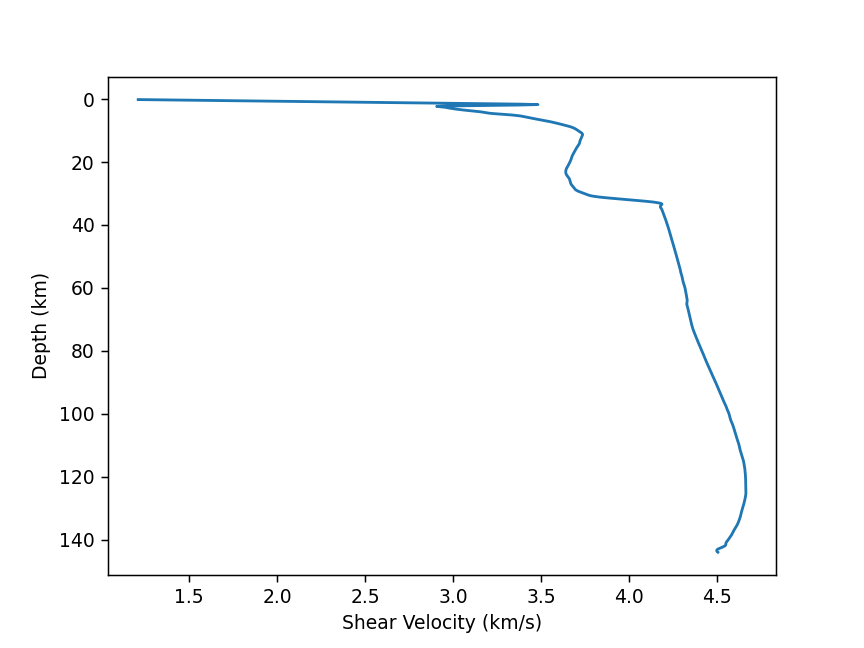

In [52]:
from disba import GroupDispersion, PhaseDispersion
import netCDF4
from scipy import interpolate

def calculate_poissons_ratio(vp, vs):
    ratio = (vp / vs) ** 2
    poisson_ratio = (ratio - 2) / (2 * ratio - 2)
    return poisson_ratio

def compute_vg(periods, model_nc, max_mode = 1, loc_stat=(62.41, -150.26), offset_lon = 3, offset_lat = 3):
    
    lats = model_nc.variables['latitude'][:].filled()
    lons = model_nc.variables['longitude'][:].filled()
    depths = model_nc.variables['depth'][:].filled()
    vs = model_nc.variables['vsfinal'][:].filled()
    vp = model_nc.variables['vpfinal'][:].filled()
    rho = model_nc.variables['rhofinal'][:].filled()
    
    idx_lat, idx_lon = np.argmin(abs(loc_stat[0]-lats)), np.argmin(abs(loc_stat[1]-lons))
    vs_profiles = vs[:, idx_lat-offset_lat:idx_lat+offset_lat, idx_lon-offset_lon:idx_lon+offset_lon]
    vp_profiles = vp[:, idx_lat-offset_lat:idx_lat+offset_lat, idx_lon-offset_lon:idx_lon+offset_lon]
    rho_profiles = rho[:, idx_lat-offset_lat:idx_lat+offset_lat, idx_lon-offset_lon:idx_lon+offset_lon]
    
    vs_profile = np.median(vs_profiles, axis=(1,2))
    new_depths = np.linspace(depths[0], depths[-1], 1000)
    kind_interp = 'quadratic'
    f = interpolate.interp1d(depths, vs_profile, kind=kind_interp)
    vs_profile = f(new_depths)[1:]
    vp_profile = np.median(vp_profiles, axis=(1,2))
    f = interpolate.interp1d(depths, vp_profile, kind=kind_interp)
    vp_profile = f(new_depths)[1:]
    rho_profile = 1.227 + 1.53*vs_profile - 0.837*vs_profile**2 + 0.207*vs_profile**3 - 0.0166*vs_profile**4
    #rho_profile = np.median(rho_profiles, axis=(1,2))[1:]
    thickness = np.diff(new_depths)
    
    # Velocity model
    # thickness, Vp, Vs, density
    # km, km/s, km/s, g/cm3
    velocity_model = np.c_[thickness, vp_profile, vs_profile, rho_profile]
    velocity_model = np.r_[velocity_model, velocity_model[-1:,:]]
    velocity_model[-1,0] = 100.
    
    pd_g = PhaseDispersion(*velocity_model.T)
    cgrs = [pd_g(periods, mode=i, wave="rayleigh") for i in range(max_mode)]
    vg0 = [cgr.velocity for cgr in cgrs]
    periods = [cgr.period for cgr in cgrs]
    
    plt.figure()
    plt.plot(vs_profile, np.cumsum(thickness))
    plt.gca().invert_yaxis()
    plt.xlabel('Shear Velocity (km/s)')
    plt.ylabel('Depth (km)')
    
    return periods, vg0

stat = [tr.stats.station for tr in st_filtered][8]
#stat = [tr.stats.station for tr in st][10]
idx_inv = np.argmax([len(net.select(station=stat))>0 for net in inventory])
print(stat)
loc_stat = (inventory[idx_inv].select(station=stat)[0].latitude, inventory[idx_inv].select(station=stat)[0].longitude)
#loc_stat = (58., -145.)
file = '/staff/quentin/Documents/Projects/2023_Venus_inversion/velocity_model/Alaska_model.nc'
model_nc = netCDF4.Dataset(file)
periods = np.logspace(-2, 2, 100)
periods, vg = compute_vg(periods, model_nc, max_mode = 6, loc_stat=(62.41, -150))

In [42]:
loc_stat

(62.1067, -146.175)

<IPython.core.display.Javascript object>


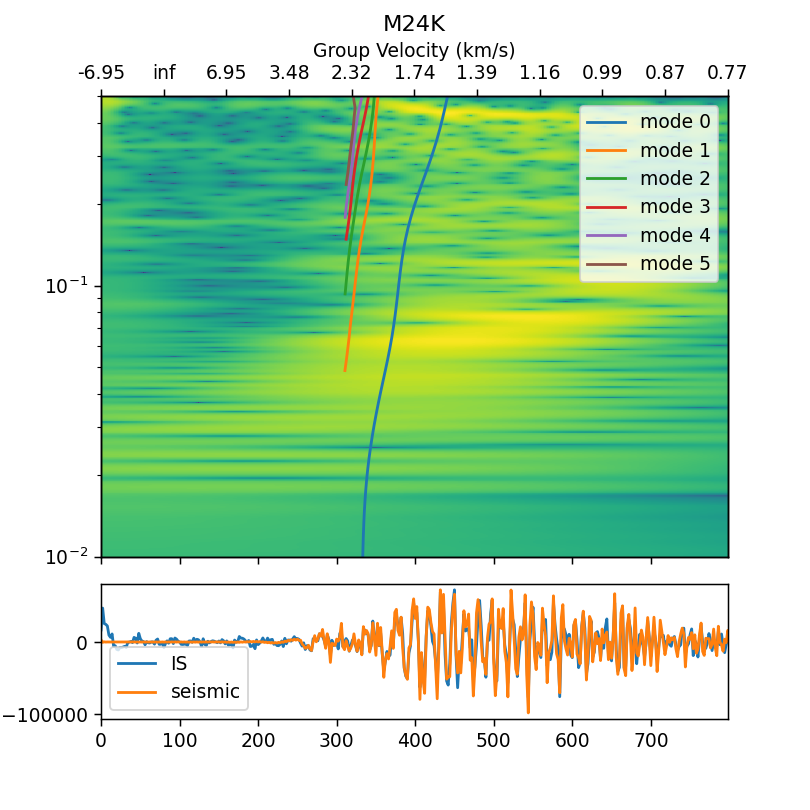

/staff/quentin/miniconda2/envs/seismonpy/lib/python3.7/site-packages/ipykernel_launcher.py:45: RuntimeWarning: divide by zero encountered in true_divide


In [54]:
def plot_cwf(tr, fmin=1e-2, fmax=10., w0=24, nf=500):
    npts = tr.stats.npts
    dt = tr.stats.delta

    scalogram = abs(cwt(tr.data, dt, w0=w0, nf=nf,
                        fmin=fmin, fmax=fmax))

    t = np.linspace(0, dt * npts, npts)
    f = np.logspace(np.log10(fmin),
                    np.log10(fmax),
                    scalogram.shape[0])
    return scalogram ** 2, f, t

freqmax = 0.5

tr = st_IS.select(station=stat)[0].copy()
tr_seismic = st.select(station=stat)[0].copy()
tr.filter('bandpass', freqmin=2e-2, freqmax=freqmax, zerophase=True, corners=6)
tr.trim(endtime=tr.stats.starttime+1500.)
tr.resample(freqmax)
tr_seismic.filter('bandpass', freqmin=2e-2, freqmax=freqmax, zerophase=True, corners=6)
tr_seismic.trim(endtime=tr.stats.starttime+1500.)
tr_seismic.resample(freqmax)
Sxx, frequencies, times_Sxx = plot_cwf(tr, fmin=1e-2, fmax=freqmax, w0=40, nf=500)

fig = plt.figure(figsize=(6,6))
grid = fig.add_gridspec(4, 1)

ax = fig.add_subplot(grid[:3,0])
ax.pcolormesh(times_Sxx, frequencies, np.log10(Sxx))
ax.set_yscale('log')
ax.set_ylim([1e-2, freqmax])
ax.set_title(tr.stats.station)

dist = tr.stats.dist
for imode in range(len(vg)):
    arr_RW = origin_time - tr.stats.starttime + dist/(vg[imode]*1e3)
    ax.plot(arr_RW, 1./periods[imode], label=f'mode {imode}')
ax.tick_params(axis='both', which='both', labelbottom=False)
ax.legend()

ax2 = ax.twiny()
new_tick_locations = ax.get_xticks()
def tick_function(X):
    V = 1e-3*dist/X
    return ["%.2f" % z for z in V]

fontsize = 10.
ax2.set_xlim(ax.get_xlim())
ax2.set_xticks(new_tick_locations)
ax2.set_xticklabels(tick_function(new_tick_locations))
ax2.tick_params(axis='both', labelsize=fontsize)
ax2.set_xlabel('Group Velocity (km/s)', fontsize=fontsize)

ax = fig.add_subplot(grid[-1,0], sharex=ax)
ax.plot(tr.times(), tr.data, label='IS')
ax.plot(tr_seismic.times(), tr.data.max()*tr_seismic.data/tr_seismic.data.max(), label='seismic')
ax.set_xlim([tr.times().min(), tr.times().max()])
ax.legend()

## Flores

In [7]:
c_event = Client("USGS")
c_event = Client("IRIS")

## Region
starttime = UTCDateTime("2016-01-01")
endtime = UTCDateTime("2023-01-01")
starttime = UTCDateTime("2021-12-13") # Flores
endtime = UTCDateTime("2021-12-15") # Flores
minmagnitude = 6.
maxdepth = 50
region = dict(minlatitude=52, maxlatitude=73, minlongitude=-170, maxlongitude=-130) # Alaska
region = dict(minlatitude=-10, maxlatitude=0, minlongitude=110, maxlongitude=130) # Flores

# Get the event information. The temporal and magnitude constraints make it unique
events = c_event.get_events(starttime=starttime, endtime=endtime, minmagnitude=minmagnitude, maxdepth=maxdepth, orderby='magnitude', **region)
print(events)

1 Event(s) in Catalog:
2021-12-14T03:20:23.917000Z |  -7.605, +122.227 | 7.3  mww


In [50]:
network = 'IU'
channel = '*'
station = '*'
tsumatra = UTCDateTime("2004-12-26T00:58:53")
t1 = tsumatra - 60 * 60 * 1
t2 = tsumatra + 60 * 60 * 4
inv = Client('IRIS').get_stations(network=network, station=station, starttime=t1, endtime=t2)
inv.select(**region)
print(inv.select(**region, starttime=starttime))

Inventory created at 2024-03-21T19:46:26.340100Z
	Created by: IRIS WEB SERVICE: fdsnws-station | version: 1.1.52
		    http://service.iris.edu/fdsnws/station/1/query?starttime=2004-12-25...
	Sending institution: IRIS-DMC (IRIS-DMC)
	Contains:
		Networks (0):

		Stations (0):

		Channels (0):



In [26]:
st = client.get_waveforms(network='*', station='SANI', location='*', channel='BHZ', starttime=origin_time+tmin, endtime=origin_time+tmax)

In [3]:
st = obspy.read('./validation_data/ev_2021-07-29T06_Mw8.2')

<IPython.core.display.Javascript object>


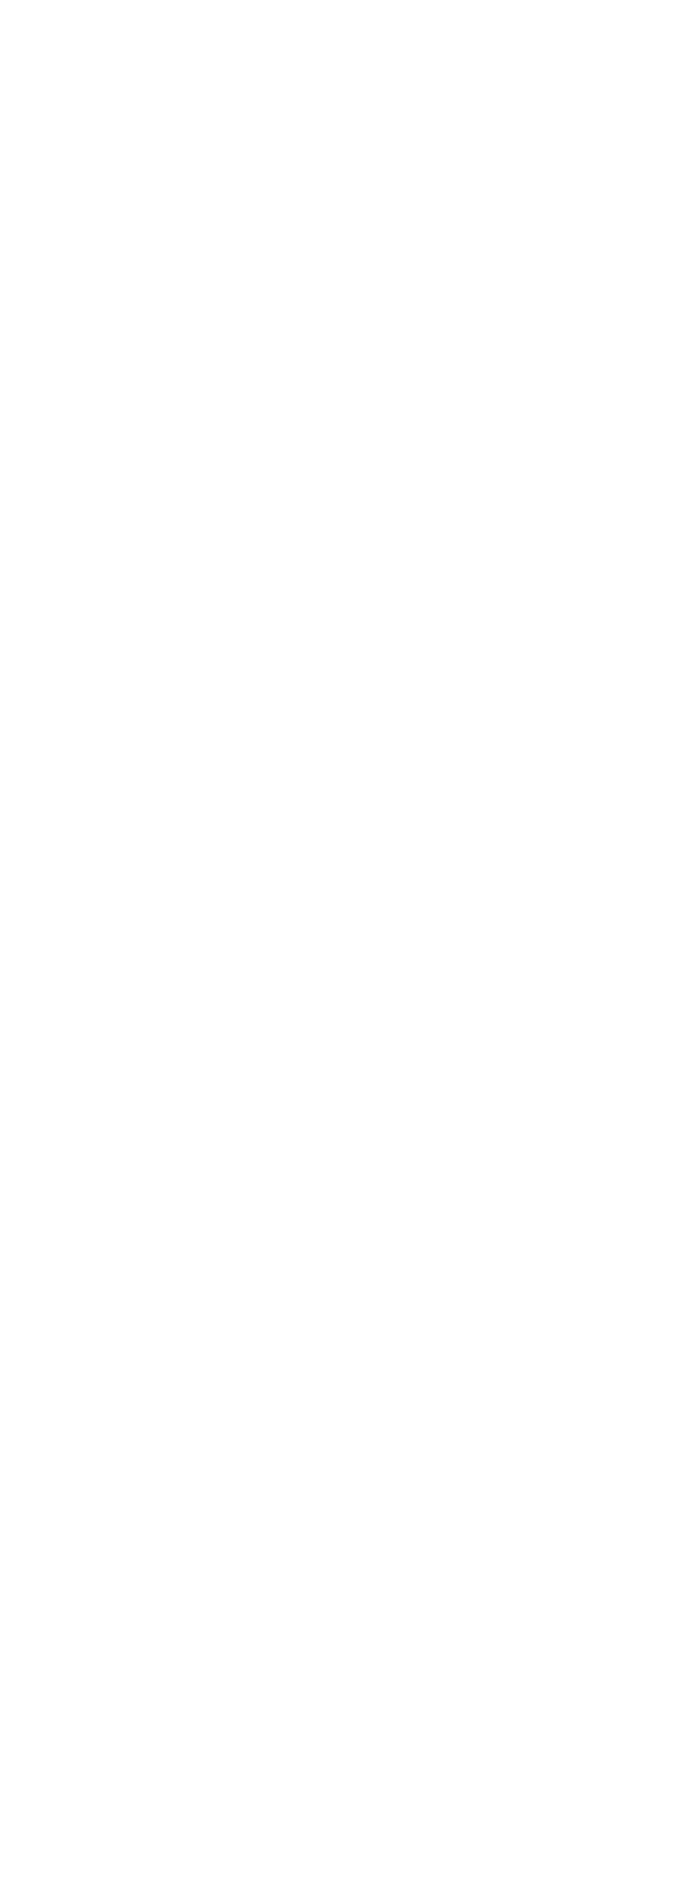

AttributeError: dist

In [7]:
def get_color_from_palette(value, palette_name='flare_r', vmin=0, vmax=1):
    """
    Maps a numerical value to a color from a Seaborn color palette.

    :param value: The numerical value to map.
    :param palette_name: The name of the Seaborn color palette to use.
    :param vmin: Minimum value for normalization.
    :param vmax: Maximum value for normalization.
    :return: The color corresponding to the given value.
    """
    # Create a color palette
    palette = sns.color_palette(palette_name, as_cmap=True)
    
    # Normalize the value
    normalized_value = (value - vmin) / (vmax - vmin)
    
    # Map the normalized value to a color
    color = palette(normalized_value)
    
    return color

file = './validation_data/ev_2021-07-29T06_Mw8.2'
st = obspy.read(file)
origin_time = st[0].stats.starttime

plt.figure(figsize=(5,14))
times = [tr.stats.starttime - origin_time for tr in st]
idx = np.argsort(times)

st_c = st.copy()
for tr in st_c:
    #tr.remove_response()
    tr.detrend()
    #tr.filter('highpass', freq=0.05)
    tr.filter('bandpass', freqmin=0.1, freqmax=0.5)
    t1 = origin_time + tr.stats.dist*1e-3/vel_RW - 120.
    t2 = t1 + 6.*60.
    tr.trim(starttime=t1, endtime=t2)
    
stds = np.array([tr.data.max()/np.std(tr.data) for tr in st_c])
for itr, tr in enumerate(st_c): 
    color = get_color_from_palette(stds[itr], vmin=stds.min(), vmax=stds.max())
    offset = tr.stats.starttime - origin_time
    plt.plot(tr.times()+offset, tr.data/(2.*tr.data.max())+np.where(idx==itr)[0][0], color=color)
    plt.text(tr.times()[-1]+offset, np.where(idx==itr)[0][0], f'{tr.stats.station} - {itr}')
plt.xlabel(f'Time (s) since {origin_time}')

In [36]:
from pyproj import Geod

wgs84_geod = Geod(ellps='WGS84')
client = Client("GEOFON")
vel_min = 1.5
vel_max = 9.

#inv = client.get_stations(network="TA", station="*", channel="BDF", starttime=starttime, endtime=endtime, level="response")

for event in events[:]:
    
    source_loc = (event.origins[0].latitude, event.origins[0].longitude)
    origin_time = event.origins[0].time
    inv_loc = inv.select(**region, starttime=origin_time, endtime=origin_time+2000.)
    station_loc = (inv_loc[0][0].latitude, inv_loc[0][0].longitude)
    stations = [stat.code for stat in inv_loc[0]]
    #print(station_loc)
    print(stations)
    #break
    _, _, range_km = wgs84_geod.inv(source_loc[1], source_loc[0], station_loc[1], station_loc[0])
    range_km /= 1e3
    tmin = range_km/vel_max
    tmax = range_km/vel_min
    
    print(event.origins[0])
    print(f'- Distance to {stations}: {range_km} km')
    print(f'- Waveform duration: {tmax-tmin} s')
    print(f'- Times: {origin_time+tmin} to {origin_time+tmax}')

    component = 'BHZ'
    st = client.get_waveforms(network='*', station=','.join(stations), location='*', channel=component, starttime=origin_time+tmin, endtime=origin_time+tmax)
    #st = client.get_waveforms(network="TA", station="*", channel="BDF", starttime=event_time - 60, endtime=event_time + 3600)
    print(st)
    if len(st) == 0:
        print('No data')
        continue
    
    
    #for tr in st:
    #    tr.stats.network = 'NO'
    #    tr.stats.calib = 1.
    #st.remove_response(inv)
    st.detrend()
    st.filter('bandpass', freqmin=0.01, freqmax=10., zerophase=True)
    break


['SANI']
Origin
	   resource_id: ResourceIdentifier(id="smi:service.iris.edu/fdsnws/event/1/query?originid=46229937")
	          time: UTCDateTime(2021, 12, 14, 3, 20, 23, 917000)
	     longitude: 122.2273
	      latitude: -7.6046
	         depth: 15060.0
	 creation_info: CreationInfo(author='at,pt,us,usauto')
- Distance to ['SANI']: 742.4599992562408 km
- Waveform duration: 412.47777736457823 s
- Times: 2021-12-14T03:21:46.412555Z to 2021-12-14T03:28:38.890333Z
1 Trace(s) in Stream:
GE.SANI..BHZ | 2021-12-14T03:21:46.419538Z - 2021-12-14T03:28:38.869538Z | 20.0 Hz, 8250 samples


/staff/quentin/miniconda2/envs/seismonpy/lib/python3.7/site-packages/obspy/signal/filter.py:62: UserWarning: Selected high corner frequency (10.0) of bandpass is at or above Nyquist (10.0). Applying a high-pass instead.
  warnings.warn(msg)


<IPython.core.display.Javascript object>


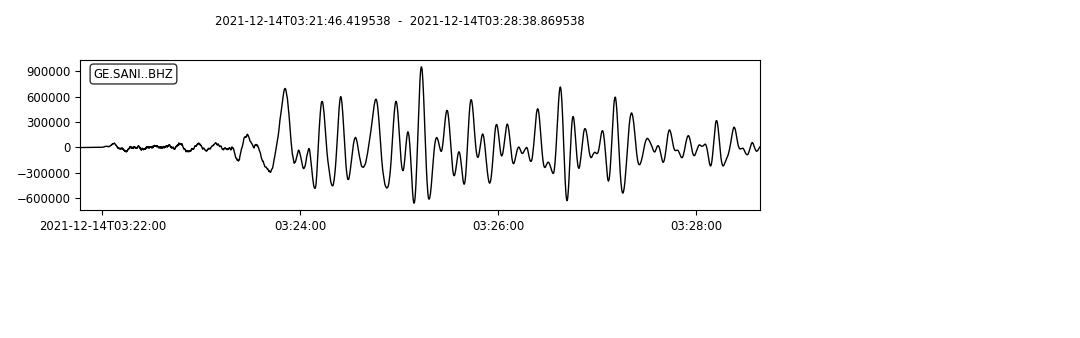

<IPython.core.display.Javascript object>


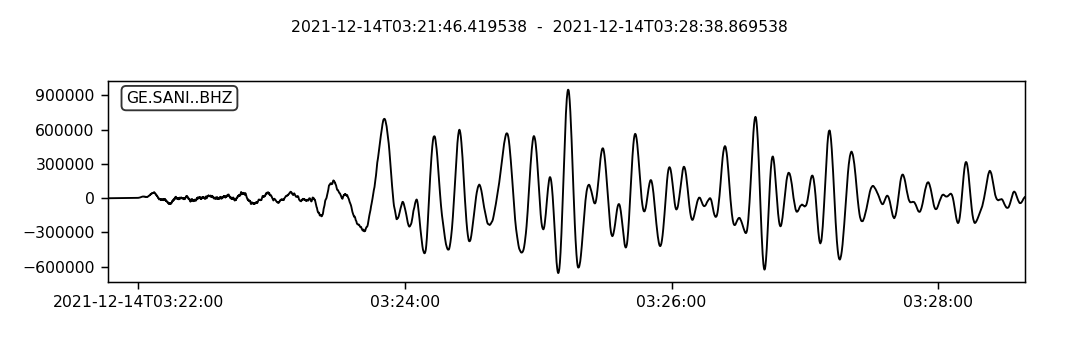

In [34]:
st.plot()

## Norwegian data + Eurasian quakes

In [2]:
c_event = Client("USGS")

## Region
starttime = UTCDateTime("2016-01-01")
endtime = UTCDateTime("2023-01-01")
minmagnitude = 6.5
maxdepth = 50
region = dict(minlatitude=10, maxlatitude=81, minlongitude=9, maxlongitude=169) # Eurasia

# Get the event information. The temporal and magnitude constraints make it unique
events = c_event.get_events(starttime=starttime, endtime=endtime, minmagnitude=minmagnitude, maxdepth=maxdepth, orderby='magnitude', **region)

In [3]:
print(events)

34 Event(s) in Catalog:
2017-07-17T23:34:13.740000Z | +54.443, +168.857 | 7.7  mww | manual
2022-03-16T14:36:30.997000Z | +37.713, +141.579 | 7.3  mww | manual
...
2020-05-02T12:51:05.561000Z | +34.182,  +25.710 | 6.5  mww | manual
2017-08-08T13:19:49.540000Z | +33.193, +103.855 | 6.5  mww | manual
To see all events call 'print(CatalogObject.__str__(print_all=True))'


In [8]:
from obspy import read_inventory
array, stations, component = 'I37NO', 'I37H*', 'BDF,HHZ'
array, stations, component = 'NORES', 'NRA0', 'HHZ'
#inv = read_inventory('/db/inventory/SEED/{}/*.SEED'.format(array))
inv = read_inventory(f'./invs/{array}.xml')
station_loc = (inv[0][0].latitude, inv[0][0].longitude)

In [22]:
from pyproj import Geod
from seismonpy.norsardb import Client as Client_NORSAR

wgs84_geod = Geod(ellps='WGS84')
client = Client_NORSAR()
vel_min = 1.5
vel_max = 7.

for event in events[18:]:
    
    source_loc = (event.origins[0].latitude, event.origins[0].longitude)
    _, _, range_km = wgs84_geod.inv(source_loc[1], source_loc[0], station_loc[1], station_loc[0])
    range_km /= 1e3
    origin_time = event.origins[0].time
    tmin = range_km/vel_max
    tmax = range_km/vel_min
    
    print(event.origins[0])
    print(f'- Distance to {array}: {range_km} km')
    print(f'- Waveform duration: {tmax-tmin} s')

    st = client.get_waveforms(stations, component, origin_time+tmin, origin_time+tmax)
    print(st)
    if len(st) == 0:
        print('No data')
        continue
    
    
    for tr in st:
        tr.stats.network = 'NO'
        tr.stats.calib = 1.
    st.remove_response(inv)
    st.detrend()
    st.filter('bandpass', freqmin=0.01, freqmax=2.5, zerophase=True)
    break

Origin
	        resource_id: ResourceIdentifier(id="quakeml:earthquake.usgs.gov/product/origin/us7000i59t/us/1668539167040/product.xml")
	               time: UTCDateTime(2022, 9, 5, 4, 52, 19, 645000)
	          longitude: 102.236
	           latitude: 29.6786
	              depth: 12000.0 [uncertainty=1746.0]
	            quality: OriginQuality(used_phase_count=141, used_station_count=141, standard_error=0.52, azimuthal_gap=34.0, minimum_distance=8.454)
	 origin_uncertainty: OriginUncertainty(horizontal_uncertainty=8190.0, preferred_description='horizontal uncertainty')
	    evaluation_mode: 'manual'
	      creation_info: CreationInfo(agency_id='us', creation_time=UTCDateTime(2022, 11, 15, 19, 6, 7, 40000))
- Distance to NORES: 7212.359595172102 km
- Waveform duration: 3777.902645090149 s
1 Trace(s) in Stream:
.NRA0..HHZ | 2022-09-05T05:09:29.987500Z - 2022-09-05T06:12:27.875000Z | 80.0 Hz, 302232 samples


<IPython.core.display.Javascript object>


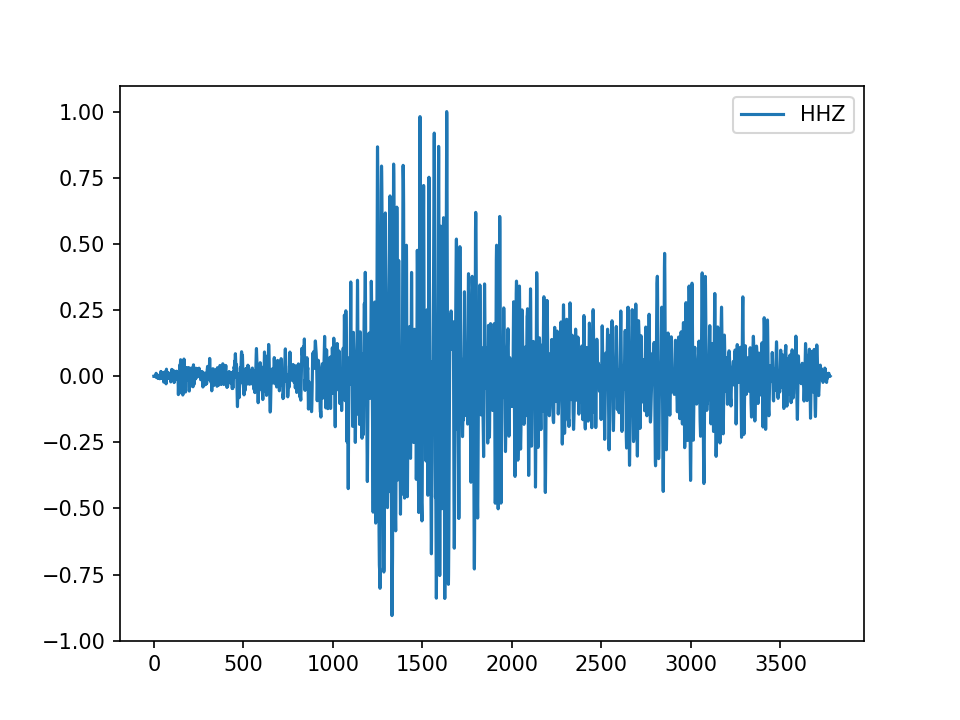

In [24]:
from scipy import signal

st_c = st.copy()
st_c.filter('bandpass', freqmin=0.01, freqmax=0.25)
#st_c.filter('highpass', freq=0.02)
#st_c.select(station='NRA2').plot(equal_scale=False)
plt.figure()
for tr in st_c:
    tr.resample(20.)
    plt.plot(tr.times(), tr.data/tr.data.max(), label=tr.stats.channel)
#corr = signal.correlate(st_c[0].data/st_c[0].data.max(), st_c[1].data/st_c[1].data.max(), mode='same')
#corr = np.correlate(a=st_c[0].data/st_c[0].data.max(), v=st_c[1].data/st_c[1].data.max())
#plt.plot(tr.times(), corr/corr.max())
#plt.title(corr)
plt.legend()